In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from pandas.plotting import parallel_coordinates
from matplotlib import animation

sns.set(style="whitegrid", context="notebook")
OUT_DIR = "assignment10_uber_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [5]:
# 1. Load dataset & inspect
# -----------------------
path = "uber.csv"
df = pd.read_csv(path, low_memory=False)
print("Loaded dataset with shape:", df.shape)
print("Columns:", list(df.columns))

# Helper pickers
def find_datetime_col(df):
    # heuristics: name contains 'date' or 'time' or 'pickup_datetime' or 'timestamp'
    for c in df.columns:
        lc = c.lower()
        if 'date' in lc or 'time' in lc or 'datetime' in lc or 'ts' in lc or 'timestamp' in lc:
            return c
    # fallback: try coercing first few columns to datetime
    for c in df.columns[:6]:
        try:
            pd.to_datetime(df[c].dropna().iloc[:20])
            return c
        except Exception:
            continue
    return None

def find_numeric_cols(df):
    return list(df.select_dtypes(include=[np.number]).columns)

def find_categorical_cols(df):
    # object, category, bool, or small-cardinality numeric
    objs = list(df.select_dtypes(include=['object','category','bool']).columns)
    # also include numeric columns with few unique values
    for c in df.select_dtypes(include=[np.number]).columns:
        if df[c].nunique() <= 10 and c not in objs:
            objs.append(c)
    return objs

datetime_col = find_datetime_col(df)
numeric_cols = find_numeric_cols(df)
categorical_cols = find_categorical_cols(df)

print("Detected datetime column:", datetime_col)
print("Numeric columns:", numeric_cols)
print("Categorical columns (candidates):", categorical_cols)



Loaded dataset with shape: (200000, 9)
Columns: ['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
Detected datetime column: pickup_datetime
Numeric columns: ['Unnamed: 0', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
Categorical columns (candidates): ['key', 'pickup_datetime', 'passenger_count']


In [7]:
# 2. Choose default columns for visualizations (with fallback)
# -----------------------
# Preferred numeric pair for scatter: try trip_distance / fare_amount or similar
pref_numeric_pairs = [
    ("trip_distance","fare_amount"),
    ("distance","fare"),
    ("distance_km","fare_amount"),
    ("distance","amount"),
    ("distance","fare_amount"),
    ("trip_distance","total_amount")
]

x_col = y_col = None
for a,b in pref_numeric_pairs:
    if a in df.columns and b in df.columns:
        x_col, y_col = a, b
        break

if x_col is None or y_col is None:
    # fallback to first two numeric columns
    if len(numeric_cols) >= 2:
        x_col, y_col = numeric_cols[0], numeric_cols[1]
    else:
        raise ValueError("Need at least two numeric columns in the dataset for scatterplots.")

# Size mapping: prefer passenger_count or duration
size_candidates = ["passenger_count","passengers","duration","trip_time_in_secs","trip_time"]
size_col = next((c for c in size_candidates if c in df.columns), None)

# Categorical hue: prefer payment_type, payment, store_and_fwd_flag, vendor_id
hue_candidates = ["payment_type","payment","store_and_fwd_flag","vendor_id","passenger_count","pickup_borough","dropoff_borough"]
hue_col = next((c for c in hue_candidates if c in df.columns), None)
# If nothing found, pick first categorical column
if hue_col is None and categorical_cols:
    hue_col = categorical_cols[0]
# If still none, create a simple binary category from median of x_col
if hue_col is None:
    df['hue_auto'] = (df[x_col] > df[x_col].median()).astype(int).astype(str)
    hue_col = 'hue_auto'

print("Using x_col =", x_col, ", y_col =", y_col, ", size_col =", size_col, ", hue_col =", hue_col)

# -----------------------


Using x_col = Unnamed: 0 , y_col = fare_amount , size_col = passenger_count , hue_col = passenger_count


In [9]:
# 3. Basic cleaning for chosen columns (drop NA rows for those)
# -----------------------
vis_cols = [x_col, y_col]
if size_col:
    vis_cols.append(size_col)
vis_cols.append(hue_col)
vis_cols = list(dict.fromkeys(vis_cols))

df_vis = df[vis_cols].copy()
# coerce numeric columns as needed
for c in [x_col, y_col, size_col]:
    if c and c in df_vis.columns:
        df_vis[c] = pd.to_numeric(df_vis[c], errors='coerce')

# drop rows missing critical values
before = len(df_vis)
df_vis = df_vis.dropna(subset=[x_col,y_col])
after = len(df_vis)
print(f"Dropped {before-after} rows with missing {x_col}/{y_col}")

Dropped 0 rows with missing Unnamed: 0/fare_amount


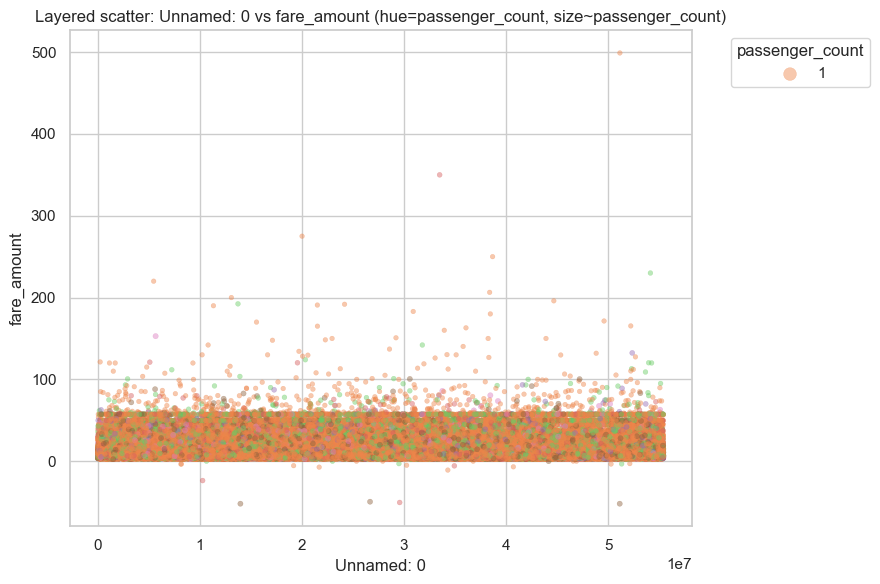

In [17]:
 #4. Layered scatter (transparency + size mapping + hue)
#    Gestalt: similarity (color), proximity (clusters), overlap via alpha
# -----------------------
plt.figure(figsize=(9,6))

# Compute custom sizes
if size_col and size_col in df_vis.columns:
    sizes = (df_vis[size_col].fillna(0).astype(float) -
             df_vis[size_col].min() + 1)
    marker_sizes = (sizes / sizes.max()) * 150 + 10
else:
    marker_sizes = np.full(len(df_vis), 40)   # Must be array, not int

# *** SUPER IMPORTANT FIX ***
# Force seaborn to IGNORE size completely
sns.scatterplot(
    data=df_vis,
    x=x_col,
    y=y_col,
    hue=hue_col,
    alpha=0.45,
    palette="muted",
    edgecolor=None,
    s=marker_sizes,
    legend=False                 # <--- CRITICAL FIX
)

# Add legend manually only for hue
plt.legend(
    title=hue_col,
    labels=df_vis[hue_col].unique(),
    bbox_to_anchor=(1.05,1),
    loc='upper left'
)

plt.title(f"Layered scatter: {x_col} vs {y_col} (hue={hue_col}, size~{size_col})")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "layered_scatter.png"), dpi=200)
plt.show()

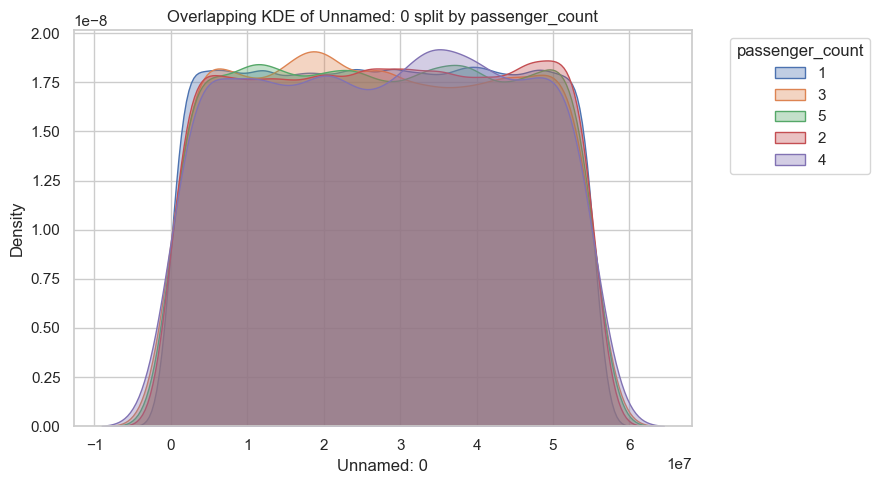

In [23]:

 


# -----------------------
# 5. Overlapping KDE/density by category (if x_col or y_col distribution meaningful)
# -----------------------
plt.figure(figsize=(9,5))
unique_hues = df_vis[hue_col].dropna().unique()[:5]  # plot at most first 5 categories
for h in unique_hues:
    subset = df_vis[df_vis[hue_col] == h][x_col]
    if len(subset) > 10:
        sns.kdeplot(subset, fill=True, alpha=0.35, label=str(h))
plt.title(f"Overlapping KDE of {x_col} split by {hue_col}")
plt.xlabel(x_col)
plt.legend(title=hue_col, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "kde_by_category.png"), dpi=200)

plt.show()



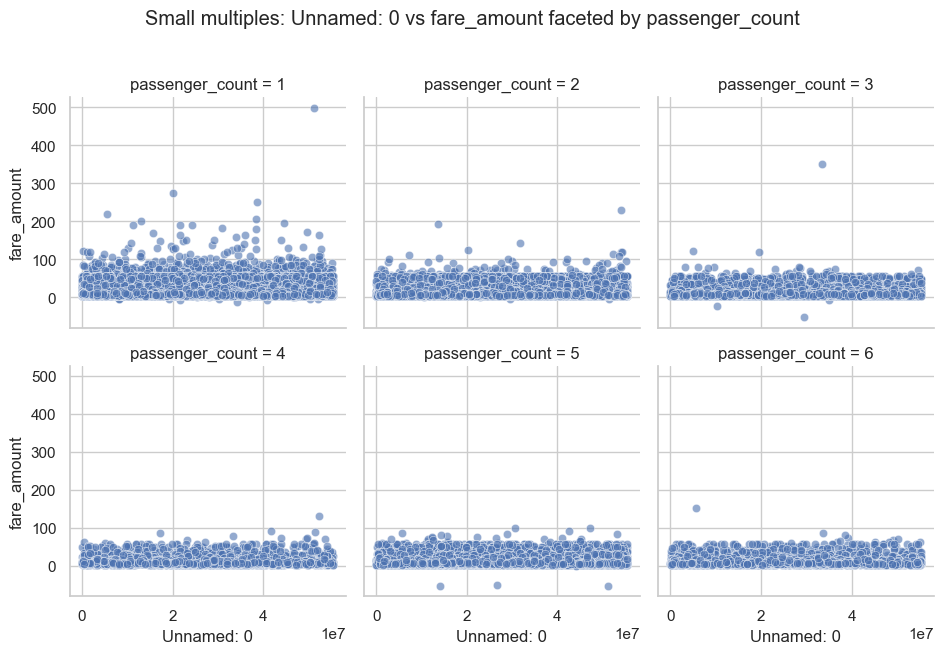

In [25]:
# 6. Small multiples (facets) by category (proximity & similarity)
# -----------------------
# pick top categories for facetting
top_cats = df_vis[hue_col].value_counts().index[:6].tolist()
facet_df = df_vis[df_vis[hue_col].isin(top_cats)].copy()
g = sns.FacetGrid(facet_df, col=hue_col, col_wrap=3, height=3.2, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x=x_col, y=y_col, alpha=0.6)
g.set_axis_labels(x_col, y_col)
g.fig.suptitle(f"Small multiples: {x_col} vs {y_col} faceted by {hue_col}", y=1.02)
g.tight_layout()
g.savefig(os.path.join(OUT_DIR, "small_multiples.png"), dpi=200)
plt.show()

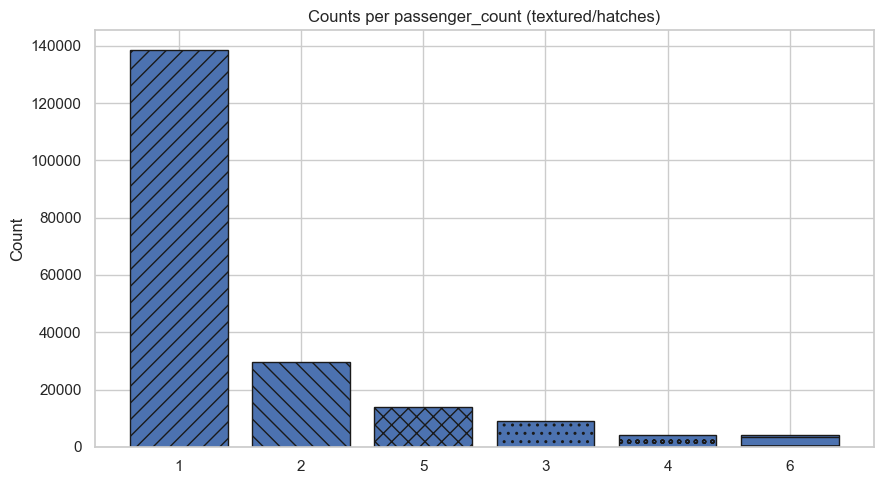

In [27]:
# 7. Textured / hatched bar chart: counts across categories
#    texture helpful for grayscale/print; Gestalt: closure via grouped bars
# -----------------------
counts = df_vis[hue_col].value_counts().loc[top_cats]
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(range(len(counts)), counts.values, tick_label=[str(x) for x in counts.index], edgecolor='k')
hatches = ['/', '\\', 'x', '.', 'o', '-']
for bar, h in zip(bars, hatches):
    bar.set_hatch(h*2)
ax.set_title(f"Counts per {hue_col} (textured/hatches)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "textured_bar_counts.png"), dpi=200)
plt.show()

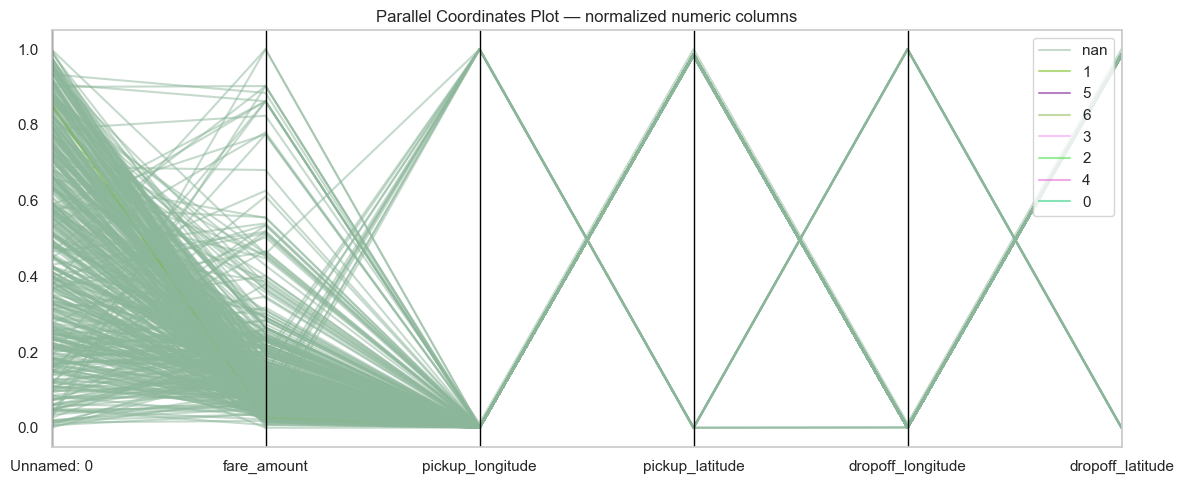

In [31]:
# -----------------------
# 8. Parallel coordinates (multidimensional discrete patterns)
#    pick up to 6 numeric columns for parallel coordinates
# -----------------------
from pandas.plotting import parallel_coordinates

# ----- FIX 1: Ensure hue column has no NaN -----
df_clean = df.dropna(subset=[hue_col]).copy()
df_clean[hue_col] = df_clean[hue_col].astype(str)   # convert to string labels

# ----- Build numeric column list -----
numeric_for_parallel = [c for c in numeric_cols if c in df_clean.columns and c not in [x_col,y_col]]

numeric_for_parallel = [x_col, y_col] + numeric_for_parallel
numeric_for_parallel = numeric_for_parallel[:6]  # Limit to max 6

# ----- Required: we need at least 3 numeric dimensions -----
if len(numeric_for_parallel) >= 3:

    pc_df = df_clean[[*numeric_for_parallel, hue_col]].dropna()

    # Sample if dataset is huge
    pc_df = pc_df.sample(n=min(500, len(pc_df)), random_state=42)

    # ----- FIX 2: Normalize columns safely -----
    pc_df_num = pc_df[numeric_for_parallel].apply(
        lambda s: (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0
    )

    # Combine numeric + category
    pc_df_norm = pd.concat([pc_df_num, pc_df[hue_col].reset_index(drop=True)], axis=1)

    # ----- PLOT -----
    plt.figure(figsize=(12,5))
    parallel_coordinates(pc_df_norm, hue_col, alpha=0.5)
    plt.title("Parallel Coordinates Plot — normalized numeric columns")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "parallel_coordinates.png"), dpi=200)
    plt.show()

else:
    print("Need at least 3 numeric columns for parallel coordinates.")


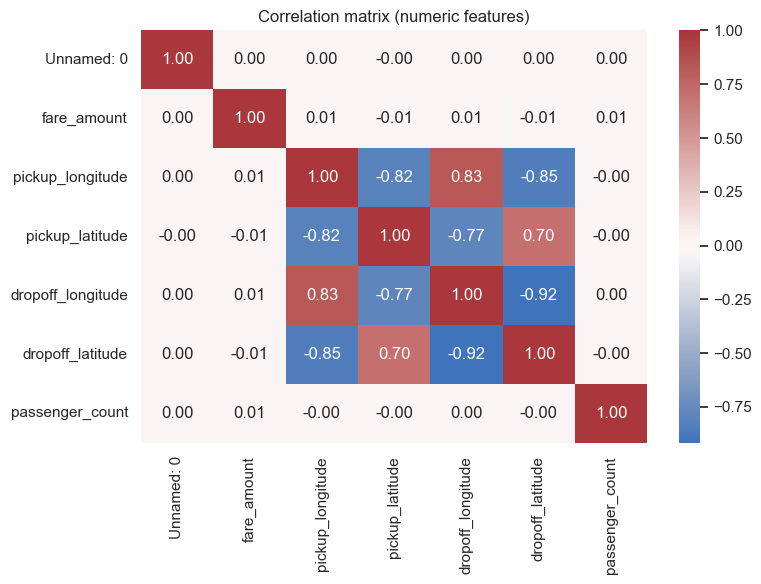

In [37]:
# 9. Correlation heatmap (matrix view)
# -----------------------
corr_cols = numeric_cols[:10]  # limit to 10 numeric columns
if len(corr_cols) >= 2:
    corrv = df[corr_cols].apply(pd.to_numeric, errors='coerce').corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corrv, annot=True, fmt=".2f", cmap="vlag", center=0)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "correlation_heatmap.png"), dpi=200)
    plt.show()

Saving animation failed (pillow/imagemagick issue). Error: 


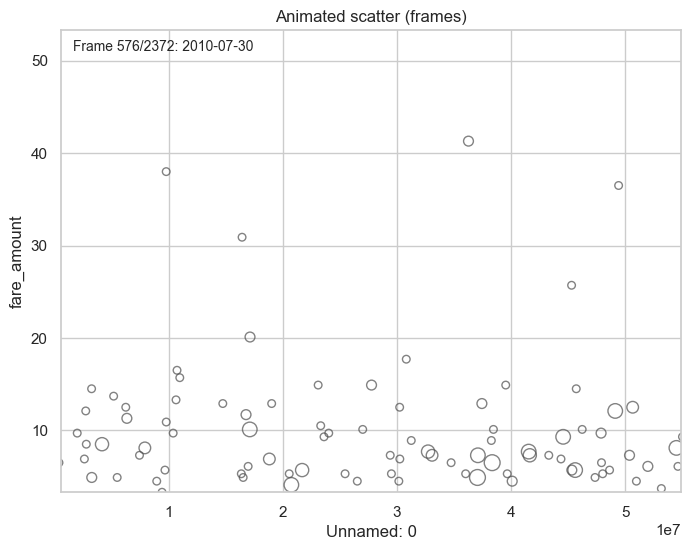

In [39]:


# -----------------------
# 10. Motion: Animated scatter grouped by time windows (if datetime exists) or by category frames
#     If datetime is available, animate by hour/day; else animate by top categories.
# -----------------------
anim_frames = []
if datetime_col:
    # parse datetime
    try:
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
        df_time = df.dropna(subset=[datetime_col, x_col, y_col])
        # create hour bins or day bins depending on span
        span_days = (df_time[datetime_col].max() - df_time[datetime_col].min()).days
        if span_days > 7:
            df_time['TimeFrame'] = df_time[datetime_col].dt.date.astype(str)  # daily frames
        else:
            df_time['TimeFrame'] = df_time[datetime_col].dt.hour.astype(str)   # hourly frames
        frames = sorted(df_time['TimeFrame'].unique())
        animate_by = 'TimeFrame'
        anim_df = df_time
    except Exception as e:
        print("Datetime parsing failed:", e)
        frames = df_vis[hue_col].dropna().unique().tolist()
        animate_by = hue_col
        anim_df = df_vis
else:
    frames = df_vis[hue_col].dropna().unique().tolist()[:8]  # up to 8 frames
    animate_by = hue_col
    anim_df = df_vis

# Prepare animation figure
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_title("Animated scatter (frames)")

sc = ax.scatter([], [], s=[], alpha=0.7)
txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, fontsize=10, va='top')

# axis limits
ax.set_xlim(df_vis[x_col].quantile(0.01), df_vis[x_col].quantile(0.99))
ax.set_ylim(df_vis[y_col].quantile(0.01), df_vis[y_col].quantile(0.99))

def init_anim():
    sc.set_offsets(np.empty((0,2)))
    sc.set_sizes([])
    sc.set_array(np.array([]))
    txt.set_text("")
    return sc, txt

def animate(i):
    frame = frames[i]
    sub = anim_df[anim_df[animate_by] == frame]
    if sub.empty:
        offsets = np.empty((0,2))
        sizes = []
        colors = []
    else:
        offsets = sub[[x_col, y_col]].dropna().values
        if size_col and size_col in sub.columns:
            raw_size = pd.to_numeric(sub[size_col], errors='coerce').fillna(1).values
            sizes = ((raw_size - raw_size.min()+1) / (raw_size.max()-raw_size.min()+1)) * 120 + 10
        else:
            sizes = np.full(len(offsets), 40)
        # color map by hue_col if different from animate_by
        if hue_col in sub.columns:
            uniq = pd.Categorical(df_vis[hue_col]).categories
            cmap = plt.get_cmap("tab10")
            color_map = {cat: cmap(i % 10) for i, cat in enumerate(uniq)}
            colors = [color_map.get(v, (0.3,0.3,0.3)) for v in sub[hue_col].astype(str)]
        else:
            colors = ['grey'] * len(offsets)
    sc.set_offsets(offsets)
    sc.set_sizes(sizes)
    sc.set_color(colors)
    txt.set_text(f"Frame {i+1}/{len(frames)}: {str(frame)}")
    return sc, txt

n_frames = len(frames) if len(frames) > 0 else 1
anim = animation.FuncAnimation(fig, animate, frames=n_frames, init_func=init_anim, blit=True, interval=800)
gif_path = os.path.join(OUT_DIR, "animated_scatter.gif")
try:
    anim.save(gif_path, writer='pillow', dpi=150)
    print("Saved animation to", gif_path)
except Exception as e:
    print("Saving animation failed (pillow/imagemagick issue). Error:", e)

plt.show(fig)

In [41]:
# 11. Quick textual summary (starter for report)
# -----------------------
summary = {
    "x_col": x_col, "y_col": y_col, "size_col": size_col, "hue_col": hue_col,
    "datetime_col": datetime_col, "n_rows": len(df), "n_vis_rows": len(df_vis)
}
print("Visualization choices summary:", summary)
print("All plots and animation (if saved) are in folder:", OUT_DIR)

Visualization choices summary: {'x_col': 'Unnamed: 0', 'y_col': 'fare_amount', 'size_col': 'passenger_count', 'hue_col': 'passenger_count', 'datetime_col': 'pickup_datetime', 'n_rows': 200000, 'n_vis_rows': 200000}
All plots and animation (if saved) are in folder: assignment10_uber_outputs
